# How to use one-shot-calculator

This notebook shows a few examples of how you can use the one_shot_calculator package. It assumes some familiarity with Python and the pandas module. There is a quick-start guide to getting started with these in the README file.

## Setup

First, import pandas and two modules from the one_shot_calculator package: process_csv and one_shot_calculator_3e (abbreviated here as osc)

In [1]:
import pandas as pd
from one_shot_calculator import process_csv
from one_shot_calculator import one_shot_calculator_3e as osc

Next, process the CSV file containing the monsters, turning it into a pandas dataframe

In [2]:
third_ed_monster_table=process_csv.process_csv_3e("Monster Compendium (Graphless).csv")

The columns of the dataframe tell you what data about the monsters is available:

In [3]:
third_ed_monster_table.columns

Index(['Creature', 'Size', 'Type', 'Subtypes', 'HD', 'hp', 'Spd',
       'SwimFlyBurrowClimb', 'AC', 'TouchAC', 'FlatFootedAC', 'Grpl', 'Attack',
       'Full Attack', 'Special Attacks', 'SLAs', 'Special Qualities', 'Fort',
       'Ref', 'Will', 'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha', 'Environment',
       'frqncy', 'Aln', 'CR', 'Book'],
      dtype='object')

## A simple enough example: sometimes, he just raged

Let's walk through a simple example: a first-level half-orc barbarian with a greataxe. We'll assume they're raging, with a total Strength of 24, so they have a +8 attack bonus and deal 1d12+10 damage on a hit.

First, we need to define a one-shot function. The one-shot function will take a pandas dataframe as input, and return the probability of one-shotting the monsters in that dataframe. I'll give the function for our half-orc friend first, then explain how it works:

In [3]:
def barbarian_one_shot(dataframe):
    return osc.prob_at_least(osc.attack_dist(8,dataframe["AC"],osc.add_const_to_dist(osc.basic_die_dist(12),10),crit_mult=3),dataframe["hp"])

The one_shot_calculator package represents probability distributions as Python dictionaries, with keys for potential outcomes and values for the probabilities. The most basic distribution you will start with is basic_die_dist. Its argument is the number of sides, so basic_die_dist(12) gives a d12. The function add_const_to_dist returns a distribution with a constant added, ideal for your Strength bonus to damage. The function attack_dist is more complicated: its arguments are the attack bonus, the AC (here taking that AC from the dataframe, which is how we will access the AC of monsters), and a damage distribution, in this case the result of add_const_to_dist. It then has a number of optional arguments: crit_range is a two-element list that gives the crit range, for example ``[18,20]`` for a rapier. crit_mult gives the crit multiplier, for example 3 for our greataxe. Other optional arguments let you take account of a bonus to confirm critical hits or bonus damage on crits that isn't a multiplier. The function attack_dist takes account of all the D&D 3.5 rules about attacks, including automatically hitting on a 20 and automatically missing on a 1, and gives the probability distribution of damage including the possibility of dealing no damage at all. Finally, prob_at_least gives the probability that a distribution will give at least a certain value, here the hp row of the dataframe. Thus, this function gives our half-orc's chance to one-shot their enemies.

Now we're ready to plug this function into one_shot_histogram. The function one_shot_histogram takes the dataframe, a minimum CR, a maximum CR, and a one-shot function, and gives a histogram of the chance of one-shotting monsters between the minimum and maximum CR.

<Axes: >

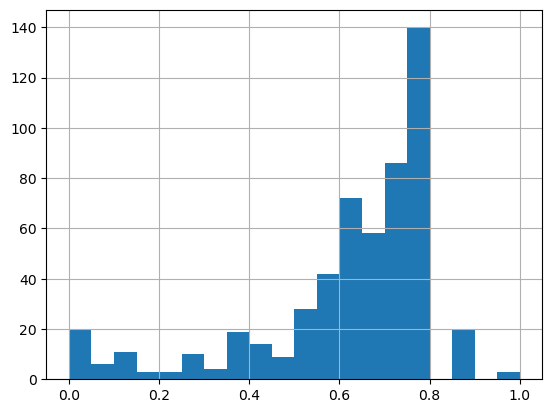

In [4]:
osc.one_shot_histogram(third_ed_monster_table,0,1,barbarian_one_shot)

Respectable! Our half-orc has between 60% and 80% chance to one-shot many level-appropriate monsters.

## A nonviolent solution

For this example, we'll use a little more optimization. A first-level wizard has a variety of spells that can take enemies out of a fight with one failed Will save, like Sleep and Color Spray. To optimize, this wizard will have the feats Sacred Vow and Vow of Nonviolence, giving them a +4 to save DCs for their spells. Like the barbarian, we'll assume they start with a base Int of 18. A spell like Sleep will then have a DC of 19. We'll also ignore that some monsters are immune to mind-affecting spells. Our one-shot function is:

In [5]:
def nonviolent_one_shot(dataframe):
    return 1-osc.save_chance(dataframe["Will"],19)

This uses the function save_chance, which takes into account that saves automatically fail on 1 and automatically succeed on 20.

<Axes: >

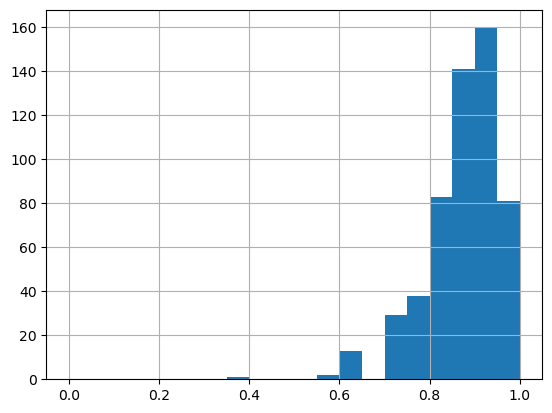

In [6]:
osc.one_shot_histogram(third_ed_monster_table,0,1,nonviolent_one_shot)

Nice! This more optimized character has a strong chance of one-shotting most level-appropriate monsters! Note that things would get a bit worse if we took into account immunity to mind-affecting spells, but there are other spells we could choose.

## On Fireball

Now a much less-optimized example, with some code subtleties. We have a 10th level wizard who really loves Fireball. They've got some appropriate wizard gear, including a Headband of Intellect +4, which brings their Int from a starting value of 18 to 22. They've got a few of the obvious Player's Handbook feats to support their Fireball-loving: Spell Focus (Evocation), Greater Spell Focus (Evocation), and Empower Spell. And they're smart enough to understand that you use area-of-effect spells like Fireball against groups of monsters. We'll assume they're facing at least four monsters with a total EL of 10, which means at least one of them is CR 6 or below. So let's look at this wizard's chances to one-shot monsters between CR 4 and CR 6.

In [5]:
def fireball_one_shot(dataframe):
    damage_dist=osc.mult_dist_by_const(osc.multiple_dist(10,osc.basic_die_dist(6)),1.5)
    return osc.prob_at_least(damage_dist if dataframe["Ref"]=="-" else osc.save_for_half_dist(dataframe["Ref"],21,damage_dist),dataframe["hp"])

New subtleties:
-mult_dist_by_const multiplies the result of a distribution by a constant. This can include fractions. In this edition of D&D, we always round down!
-multiple_dist, in contrast, adds together the results of several copies of the same distribution. We need it here to find 10d6.
-Not every monster has a reflex save! A monster with Dex - always fails reflex saves, so we have to take that into account.
-save_for_half_dist gives the distribution of damage dealt when one can save for half damage. This uses the save_chance function above

<Axes: >

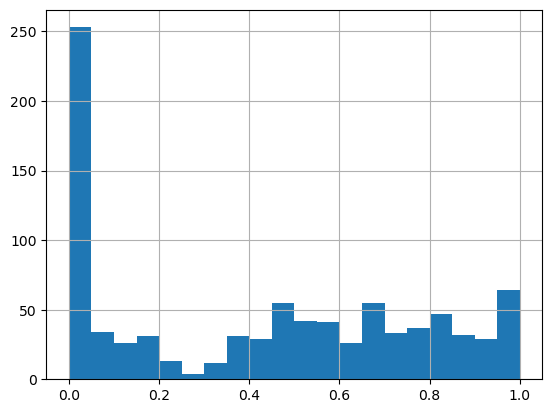

In [6]:
osc.one_shot_histogram(third_ed_monster_table,4,6,fireball_one_shot)

That's...not great! There are a lot of level-appropriate monsters this character can't one-shot at all. And I haven't taken into account fire immunity, or spell resistance, or Evasion...

In this edition, friends don't let friends prepare Fireball.